--- Data Load ---
shape: (65188, 46)
------------------------------
--- Summary Statistics ---
                      count          mean           std         min  \
POS                 65188.0  7.757594e+07  5.974051e+07  961.000000   
AF_ESP              65188.0  1.451052e-02  5.779541e-02    0.000000   
AF_EXAC             65188.0  1.449218e-02  5.954210e-02    0.000000   
AF_TGP              65188.0  1.526350e-02  5.952741e-02    0.000000   
ORIGIN              65188.0  1.342486e+00  5.688772e+00    0.000000   
SSR                   130.0  2.269231e+00  4.190777e+00    1.000000   
CLASS               65188.0  2.521016e-01  4.342226e-01    0.000000   
DISTANCE              108.0  8.257315e+02  1.069363e+03    1.000000   
STRAND              65174.0 -6.659097e-03  9.999855e-01   -1.000000   
MOTIF_POS               2.0  1.000000e+00  0.000000e+00    1.000000   
MOTIF_SCORE_CHANGE      2.0 -8.000000e-02  2.404163e-02   -0.097000   
LoFtool             60975.0  3.450584e-01  3.612384e-

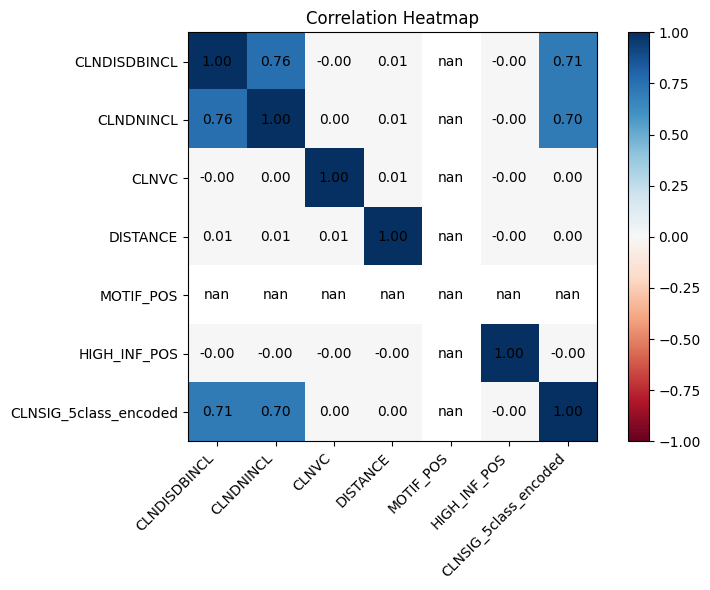

/tmp/ipython-input-4158803517.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


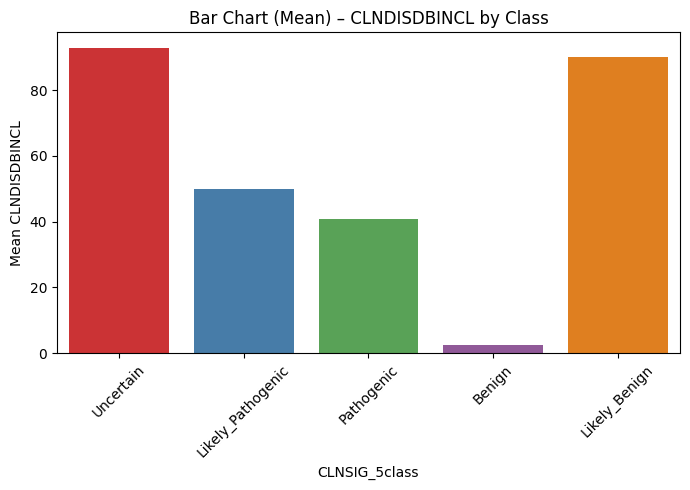

/tmp/ipython-input-4158803517.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


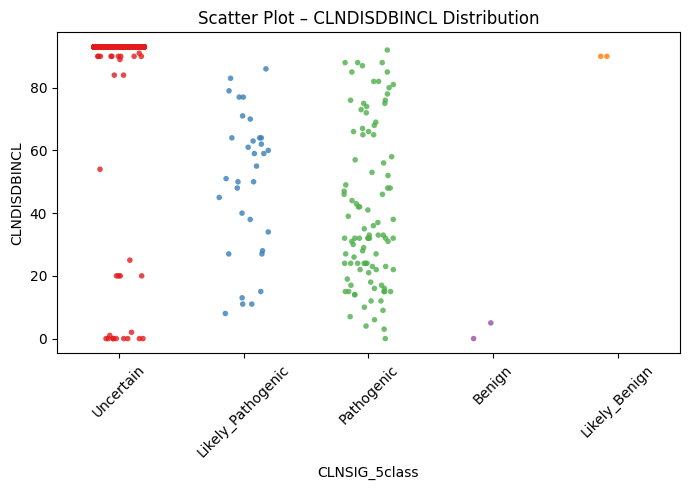

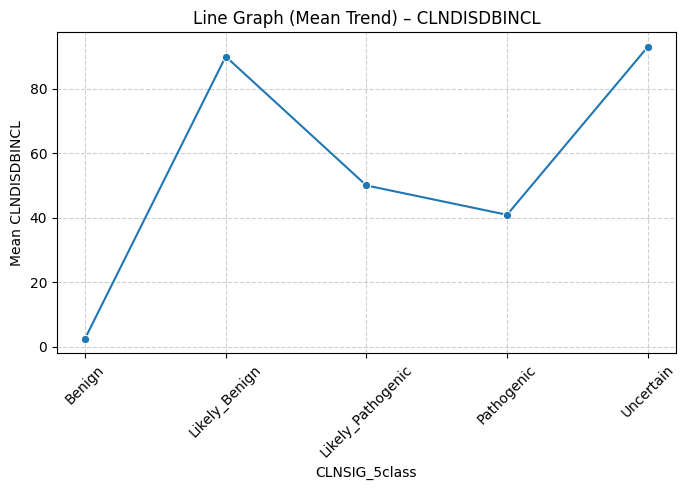

In [1]:
#Import Libraries

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

FILE_PATH = "/content/clinvar_conflicting.csv"
df = pd.read_csv(FILE_PATH, low_memory=False)

print("--- Data Load ---")
print(f"shape: {df.shape}")
print("-" * 30)

# Summary Statistics

print("--- Summary Statistics ---")
print(df.select_dtypes(include=[np.number]).describe().T)
print("-" * 30)

# Target Column - clnsigincl (Likely_Benign, Likely_Pathogenic, Pathogenic, Benign, Uncertain)
target_candidates = [c for c in df.columns if c.strip().lower() == "clnsigincl"]

if len(target_candidates) == 0:
    # Error handling for missing target column
    raise ValueError("Column 'CLNSIGINCL' NOT FOUND. Check column names.")
else:
    target_col = target_candidates[0]
    print(f"--- Target Column Found ---")
    print(f"Target column (raw): {target_col}")
    print("-" * 30)

# Create 5 class target variable

def classify_label(value):
    if pd.isna(value):
        return "Uncertain"

    v = str(value).lower()

    if "likely_benign" in v:
        return "Likely_Benign"
    if "likely_pathogenic" in v:
        return "Likely_Pathogenic"
    if "benign" in v and "likely" not in v:
        return "Benign"
    if "pathogenic" in v and "likely" not in v:
        return "Pathogenic"
    if "uncertain" in v or "risk_factor" in v or "other" in v:
        return "Uncertain"

    return "Uncertain"

df["CLNSIG_5class"] = df[target_col].apply(classify_label)

print(f"--- 5-Class Target Created ---")
print("Target class distribution:")
print(df["CLNSIG_5class"].value_counts())
print("-" * 30)

# Remove Duplicates

dup_count = df.duplicated().sum()
if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)

print(f"Duplicates Removed")
print("-" * 30)

# Numerical and Categorical columns detection

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
coerced_cols = []
for c in df.select_dtypes(include=["object"]).columns:
    coerced = pd.to_numeric(df[c], errors="coerce")
    if coerced.notna().mean() > 0.6:
        df[c + "_coerced"] = coerced
        coerced_cols.append(c + "_coerced")
        numeric_cols.append(c + "_coerced")

numeric_cols = list(dict.fromkeys(numeric_cols))
cat_cols = [c for c in df.columns if c not in numeric_cols and c != "CLNSIG_5class"]

# Remove fully missing numeric columns if exist
numeric_with_nans = [c for c in numeric_cols if df[c].isna().any()]
fully_missing = [c for c in numeric_with_nans if df[c].notna().sum() == 0]

df = df.drop(columns=fully_missing)
numeric_with_nans = [c for c in numeric_with_nans if c not in fully_missing]

# Handle missing values  by mean

mean_df = df.copy()
if numeric_with_nans:
    imputer = SimpleImputer(strategy="mean")
    mean_df[numeric_with_nans] = imputer.fit_transform(mean_df[numeric_with_nans])
df = mean_df

print(f"--- Handling missing values ---")
print(f"Columns handled: {numeric_with_nans}")
print("-" * 30)



# Handling outliers by IQR

def handle_outliers(series):
    if not np.issubdtype(series.dtype, np.number):
        return series
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    if iqr == 0:
        return series
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return series.clip(lower, upper)

current_numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in current_numeric_cols:
    df[col] = handle_outliers(df[col])

print(f"Handled outliers by IQR")
print("-" * 30)

# Encoding - Label Encoding for all categorical features

df = df.drop(columns=[target_col])

all_obj_cols_for_le = [c for c in df.columns if df[c].dtype == object and c != "CLNSIG_5class"]

le_dropped_cols = []
for c in all_obj_cols_for_le:
    try:
        # Convert to string to handle NaNs/None explicitly before encoding
        df[c] = LabelEncoder().fit_transform(df[c].astype(str))
    except:
        df = df.drop(columns=[c])
        le_dropped_cols.append(c)

# Encode 5-class target
le_target = LabelEncoder().fit(df["CLNSIG_5class"])
df["CLNSIG_5class_encoded"] = le_target.transform(df["CLNSIG_5class"])

target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
print(target_mapping)

# Feature selection

X = df.drop(columns=["CLNSIG_5class", "CLNSIG_5class_encoded"])
y = df["CLNSIG_5class_encoded"]

X_num = X.select_dtypes(include=[np.number]).fillna(0)

mi_scores = mutual_info_classif(X_num, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X_num.columns).sort_values(ascending=False)

top6 = mi_series.head(6).index.tolist()

print(f"--- Feature Selection ---")
print(f"Top 6 features based on MI score:")
print(mi_series.head(6))

# Correlation plot (Heat Matrix)

corr = df[top6 + ["CLNSIG_5class_encoded"]].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap="RdBu", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)

for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}", ha="center", va="center")

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show() # Display the plot

# Exploratory data analysis

target_feature = top6[0] # Using the top feature: CLNDISDBINCL

# 1. Bar Chart
plt.figure(figsize=(7, 5))
sns.barplot(
    x="CLNSIG_5class",
    y=df[target_feature],
    data=df,
    palette="Set1",
    errorbar=None
)
plt.title(f"Bar Chart (Mean) – {target_feature} by Class")
plt.xlabel("CLNSIG_5class")
plt.ylabel(f"Mean {target_feature}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() # Display the plot

# 2. Scatter Plot
plt.figure(figsize=(7, 5))
sns.stripplot(
    x="CLNSIG_5class",
    y=df[target_feature],
    data=df,
    jitter=0.2,
    alpha=0.8, # Increased opacity for thicker color
    palette="Set1",
    size=4     # Increased dot size
)
plt.title(f"Scatter Plot – {target_feature} Distribution")
plt.xlabel("CLNSIG_5class")
plt.ylabel(target_feature)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() # Display the plot

# 3. Line Graph
# Calculate mean per class
mean_per_class = df.groupby("CLNSIG_5class_encoded")[target_feature].mean().reset_index()

plt.figure(figsize=(7, 5))
sns.lineplot(
    x="CLNSIG_5class_encoded",
    y=target_feature,
    data=mean_per_class,
    marker='o'
)
# Find unique encoded values and their corresponding class labels for ordered x-axis labels
unique_classes = df[["CLNSIG_5class", "CLNSIG_5class_encoded"]].drop_duplicates().sort_values("CLNSIG_5class_encoded")
x_ticks = unique_classes["CLNSIG_5class_encoded"].tolist()
x_labels = unique_classes["CLNSIG_5class"].tolist()

plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45)
plt.title(f"Line Graph (Mean Trend) – {target_feature}")
plt.xlabel("CLNSIG_5class")
plt.ylabel(f"Mean {target_feature}")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show() # Display the plot
